# CommonRoad CLCS - Getting Started

This tutorial shows you how to create a curvilinear coordinate system using CommonRoad scenarios. The curvilinear coordinate system is aligned with a given reference path. Any point (x,y) in the cartesian frame is described by the coordinates (s,d) in the curvilinear frame, where s is the arc length along the reference path and d the lateral deviation to the reference path.

Before starting this tutorial, make sure that you have gone through the tutorial for CommonRoad-IO and have installed all necessary dependencies according to the installation manual.

This tutorial further requires the [commonroad-route-planner](https://commonroad.in.tum.de/tools/route-planner): Please make sure you have installed it in your environment.

## 1. Imports

In [70]:
%matplotlib inline

import os
from matplotlib import pyplot as plt

# commonroad-io
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.mp_renderer import MPRenderer

# commonroad-route-planner
from commonroad_route_planner.route_planner import RoutePlanner
from commonroad_route_planner.reference_path_planner import ReferencePathPlanner

# commonroad-clcs
from commonroad_clcs.clcs import CurvilinearCoordinateSystem
from commonroad_clcs.ref_path_processing.factory import ProcessorFactory
from commonroad_clcs.helper.visualization import plot_scenario_and_clcs
from commonroad_clcs.config import (
    CLCSParams,
    ProcessingOption,
    ResamplingOption
)

## 2. Load CommonRoad scenario

In [71]:
# scenario name
scenario_name = 'USA_US101-3_1_T-1.xml'

# load scenario and planning problem
file_path = os.path.join(os.getcwd(), "../", scenario_name)
scenario, planning_problem_set = CommonRoadFileReader(file_path).open()
planning_problem = list(planning_problem_set.planning_problem_dict.values())[0]

## 3. Plan initial reference path

Constructing a curvilinear coordinate system requires a reference path. In our case, reference paths are represented by 2d-polylines, i.e., list of points in (x, y) Cartesian coordinates.

A reference path can be any polyline, e.g., the centerline of a lane or a route within the lanelet network. In this tutorial we generate an initial reference path using the commonroad-route-planner, which creates a reference path for the scenario leading from the initial position to the goal region.

In [72]:
# plan routes and reference path
routes = RoutePlanner(scenario.lanelet_network, planning_problem).plan_routes()
ref_path = ReferencePathPlanner(
    lanelet_network=scenario.lanelet_network,
    planning_problem=planning_problem,
    routes=routes
).plan_shortest_reference_path().reference_path

## 4. Pre-process reference path

The polyline of the initial reference path from the map or from the route planner is not necessarilly suited to construct a CLCS. Issues such as discontinuities, insufficient smoothness of curvature or too many points lead to problems when using the curvilinear frame.

Our package has various methods for pre-processing the reference path w.r.t. the aforementioned issues (see `commonroad_clcs/ref_path_processing/`.

For demonstration, we here use a simple B-spline smoothing followed by an adaptive resampling (i.e., increased sampling density for higher curvature parts). 

In [73]:
# initialize default CLCS parameter
params = CLCSParams()

We now set the desired processing options in the parameter sctruct and invoke the reference path processing:

In [74]:
# set options (see config.py for other possible parameters)
params.processing_option = ProcessingOption.SPLINE_SMOOTHING
params.resampling.option = ResamplingOption.ADAPTIVE

# pre-process reference path
ref_path_processor = ProcessorFactory.create_processor(params)
ref_path = ref_path_processor(ref_path)

## 5. Construct CLCS 

We now construct the curvilinear coordinate system object and show how to transform an exemplary point from Cartesian to Curvilinear and vice-versa.

In [75]:
# construct CLCS
# (we set preprocess_path = False, since we have already done a pre-processing in the previous section)
curvilinear_cosy = CurvilinearCoordinateSystem(
    reference_path=ref_path,
    params=params,
    preprocess_path=False
)

We now transform an exemplary Cartesian point given by it's (x, y) coordinates:

In [76]:
# Cartesian point
cartesian_pt = [20.0, -40.0]
# transform to curvilinear
curvilinear_pt = curvilinear_cosy.convert_to_curvilinear_coords(cartesian_pt[0], cartesian_pt[1])
# get projected point on reference path in Cartesian coordinates
projected_pt = curvilinear_cosy.convert_to_cartesian_coords(curvilinear_pt[0], 0.0)

## 6. Visualize 

We visualize the scenario with the CLCS as well as the transformed point

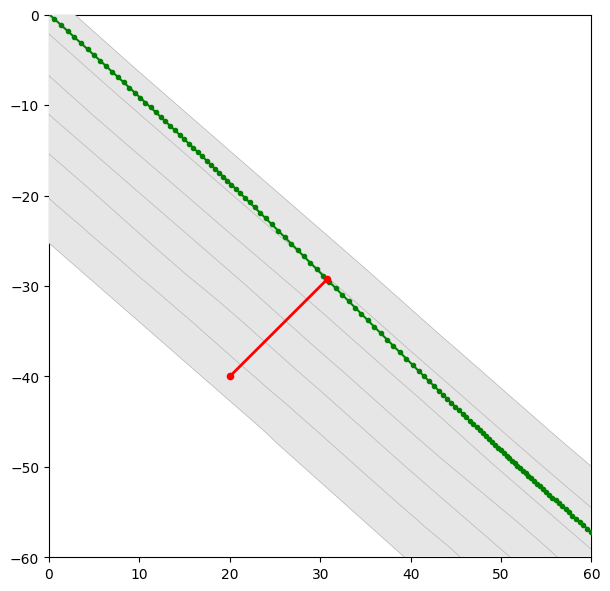

In [77]:
# plot scenario with CLCS
rnd = MPRenderer(figsize=(7, 10), plot_limits=[0.0, 60.0, -60.0, 0.0])
plot_scenario_and_clcs(
    scenario,
    curvilinear_cosy,
    renderer=rnd,
    proj_domain_plot=None
)
# plot transformed point
rnd.ax.plot([cartesian_pt[0], projected_pt[0]], [cartesian_pt[1], projected_pt[1]],
            zorder=100, linewidth=2, marker='.', markersize=9, color='red')
plt.show()